<!DOCTYPE html>
<html>
  <body>
    <div align=center>
      <h1><b>Organización de Datos</b></h1>
      <p>Cátedra Rodriguez - 95.58</p>
      <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/FIUBA_gris_transparente.png/800px-FIUBA_gris_transparente.png" alt="logo" width="300">
      <h2><b>Trabajo Práctico N°2: Críticas cinematográficas</b></h2>
    </div>
    <h3>Integrantes del <b>Grupo 17 (Systeam)</b></h3>
    <ul>
        <li>Agha Zadeh Dehdeh, Lucía. P: 106905</li>
        <li>Brizuela, Sebastián. P: 105288</li>
        <li>Del Rio, Juan Sebastián. P: 103337</li>
    </ul>
  </body>
</html>

# Librerías

In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
from sklearn.pipeline import make_pipeline

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#Modelos y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

#Redes
import keras
from keras.regularizers import L1L2

#Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Dataframe principal

##Carga del dataframe

In [ ]:
DF_CRITICAS_TRAIN = pd.read_csv("/content/sample_data/train.csv")

In [ ]:
df_criticas_copy = DF_CRITICAS_TRAIN.copy()

#Análisis exploratorio

## Cantidad de filas y columnas

In [ ]:
print(f"Filas: {DF_CRITICAS_TRAIN.shape[0]}")
print(f"Columnas: {DF_CRITICAS_TRAIN.shape[1]}")

Filas: 50000
Columnas: 3


## Tipos de datos del dataframe

In [ ]:
DF_CRITICAS_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
DF_CRITICAS_TRAIN.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Registros duplicados

In [ ]:
DF_CRITICAS_TRAIN[DF_CRITICAS_TRAIN.duplicated()]

,ID,review_es,sentimiento


## Datos faltantes

In [ ]:
filas_totales = DF_CRITICAS_TRAIN.shape[0]
porcentaje_faltante = (DF_CRITICAS_TRAIN.isna().sum() / filas_totales * 100).map("{:.2f}%".format)
cantidad_faltante = DF_CRITICAS_TRAIN.isna().sum()

resultado = pd.concat([porcentaje_faltante, cantidad_faltante], axis=1)
resultado.columns = ["Porcentaje", "Cantidad"]
print(resultado)

            Porcentaje  Cantidad
ID               0.00%         0
review_es        0.00%         0
sentimiento      0.00%         0


#Preprocesamiento

##Sacar críticas en inglés

In [ ]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=e057d3c92ad68046932f684ac83fdf036e2eaff74717bf89d70addae1051f81b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langdetect import detect

def detectar_idioma(text):
    try:
        return detect(text)
    except:
        return 'desconocido'  # Si no se puede detectar el idioma, se marca como desconocido

# Se aplica la detección de idioma a cada critica y se crea una nueva columna 'idioma'
df_criticas_copy['idioma'] = df_criticas_copy['review_es'].apply(detectar_idioma)

# Filtrar y conservar solo las criticas que no están en inglés
df_criticas_esp = df_criticas_copy[df_criticas_copy['idioma'] != 'en']

In [ ]:
#Críticas en español
df_criticas_copy[df_criticas_copy['idioma'] != 'en']

,ID,review_es,sentimiento,idioma
0,0,Uno de los otros críticos ha mencionado que de...,positivo,es
1,1,Una pequeña pequeña producción.La técnica de f...,positivo,es
2,2,Pensé que esta era una manera maravillosa de p...,positivo,es
3,3,"Básicamente, hay una familia donde un niño peq...",negativo,es
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo,es
...,...,...,...,...
49995,49995,Pensé que esta película hizo un buen trabajo a...,positivo,es
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo,es
49997,49997,Soy católica enseñada en escuelas primarias pa...,negativo,es
49998,49998,Voy a tener que estar en desacuerdo con el com...,negativo,es


In [ ]:
#Críticas en inglés
df_criticas_copy[df_criticas_copy['idioma'] == 'en']

,ID,review_es,sentimiento,idioma
156,156,From the film's first shot - Keira Knightley a...,negativo,en
249,249,'Airport 4' is basically a slopped together me...,negativo,en
250,250,"Supposedly a ""social commentary"" on racism and...",negativo,en
263,263,"There is a difference between a ""film,"" and a ...",negativo,en
264,264,please re-watch all 3 series and do not go see...,negativo,en
...,...,...,...,...
49772,49772,CitizenX(1995) is the developing world's answe...,positivo,en
49792,49792,"Thirty years after its initial release, the th...",positivo,en
49833,49833,THE SHOP AROUND THE CORNER is one of the sweet...,positivo,en
49861,49861,"OK OK, it might be hard to put the entirety of...",negativo,en


In [ ]:
#Se elimina la columa "idioma" ya que no se va a volver a utilizar
df_criticas_esp.drop('idioma', axis="columns", inplace=True)

<ipython-input-17-c2665a6c7d18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_criticas_esp.drop('idioma', axis="columns", inplace=True)


##Reemplazar negativo y positivo por 0 y 1

In [ ]:
df_criticas_esp["sentimiento"] = df_criticas_esp["sentimiento"].replace({"negativo": 0, "positivo": 1})

<ipython-input-18-3aaee458865a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_criticas_esp["sentimiento"] = df_criticas_esp["sentimiento"].replace({"negativo": 0, "positivo": 1})


##Eliminar los caracteres especiales

In [ ]:
# Función para reemplazar los caracteres especiales por espacios manteniendo las letras con tildes
def eliminar_caracteres_especiales(texto):
    return re.sub(r'[^a-zA-Z\sáéíóúüÁÉÍÓÚÜñÑ]', ' ', texto)

df_criticas_esp['review_es'] = df_criticas_esp['review_es'].apply(eliminar_caracteres_especiales)

<ipython-input-19-8261d1883038>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_criticas_esp['review_es'] = df_criticas_esp['review_es'].apply(eliminar_caracteres_especiales)


## División de datos entrenamiento y prueba

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_criticas_esp.review_es,
                                                    df_criticas_esp.sentimiento,
                                                    test_size = 0.2,
                                                    random_state = 17)

In [ ]:
y_train.value_counts()

0    19318
1    19228
Name: sentimiento, dtype: int64

In [ ]:
y_test.value_counts()

1    4822
0    4815
Name: sentimiento, dtype: int64

In [ ]:
print(f"# Datos Entrenamiento: {len(x_train)}")
print(f"# Datos Prueba: {len(x_test)}")

# Datos Entrenamiento: 38546
# Datos Prueba: 9637


In [ ]:
x_train.head()

35392    La batalla en Elderbrush Gulch fue la corta má...
47229     Realmente necesitamos más basura narcisista e...
31818    Aquí hay una joya rara para aquellos de ustede...
16857        sin nada para ir  Esta película comienza c...
8487     Lo que comienza como un hilo de país suave  in...
Name: review_es, dtype: object

# Vectorizer

In [ ]:
# Carga las stopwords en español de NLTK
spanish_stopwords = stopwords.words('spanish')

# Crea un objeto TfidfVectorizer y configura las stopwords
vectorizer = TfidfVectorizer(stop_words=spanish_stopwords, strip_accents='unicode')

#Bayes Naive

In [ ]:
#Entrenamos el modelo con TfidfVectorizer()
modelo_bn = make_pipeline(vectorizer, MultinomialNB())
modelo_bn.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvie

## Predicción

In [ ]:
prediccion_bayes = modelo_bn.predict(x_test)

##Métricas

In [ ]:
#Calculamos las métricas
print("Accuracy: ", accuracy_score(y_test, prediccion_bayes))
print("Precision: ", precision_score(y_test, prediccion_bayes))
print("Recall: ", recall_score(y_test, prediccion_bayes))
print("f1 score: ", f1_score(y_test, prediccion_bayes))

TfidfVectorizer
Accuracy:  0.8646
Precision:  0.8548726785372391
Recall:  0.8822367121122308
f1 score:  0.8683391676390508


##Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

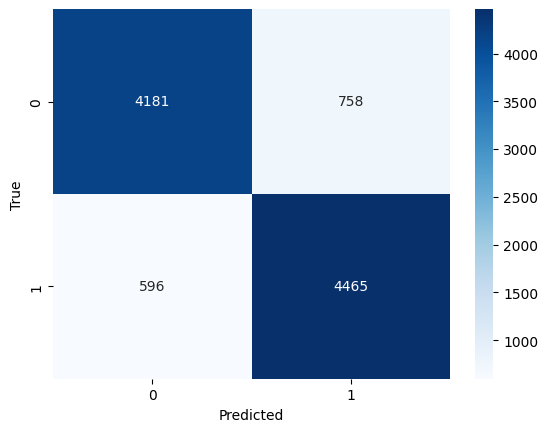

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, prediccion_bayes)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Bayes Naive y RandomSearchCV

In [ ]:
# Definir el pipeline con TfidfVectorizer y MultinomialNB
pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('bn', MultinomialNB())
])

# Definir el espacio de búsqueda de hiperparámetros
params_bn = {
    'tfidf__max_features': [10000, 25000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
    'bn__alpha': uniform(0.1, 1.0),
    'bn__fit_prior': [True, False],
    'bn__class_prior': [None, [0.3, 0.4, 0.3]]
}

# Configurar RandomizedSearchCV con el pipeline
rand_bn = RandomizedSearchCV(pipeline,
                            param_distributions=params_bn,
                            n_iter=10,
                            cv=5,
                            random_state=42)

rand_bn.fit(x_train, y_train)

In [ ]:
# Mejores hiperparametros
print("Mejores parámetros:", rand_bn.best_params_)

# Mejor métrica
print("Mejor precisión:", rand_bn.best_score_)

### Bayes Naive con mejores parámetros

In [ ]:
bn_mejores_parametros = rand_bn.best_estimator_

### Predicción

In [ ]:
y_pred_bayes = bn_mejores_parametros.predict(x_test)

##Métricas

In [ ]:
#Calculo las métricas TfidfVectorizer()
print("TfidfVectorizer")
print("Accuracy: ", accuracy_score(y_test, y_pred_bayes))
print("Precision: ", precision_score(y_test, y_pred_bayes))
print("Recall: ", recall_score(y_test, y_pred_bayes))
print("f1 score: ", f1_score(y_test, y_pred_bayes))

TfidfVectorizer
Accuracy:  0.8867
Precision:  0.8864620228256592
Recall:  0.8901402884805374
f1 score:  0.8882973479246771


##Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

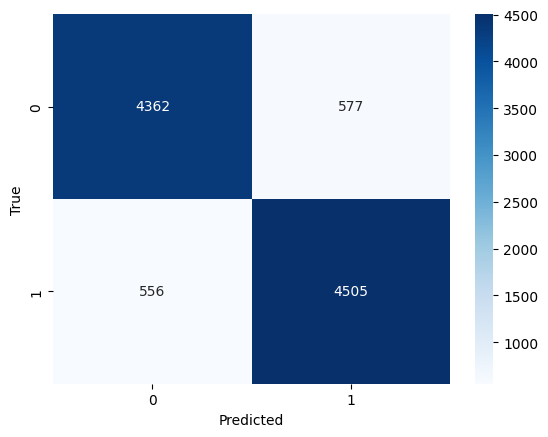

In [ ]:
#Matriz de Confusión TfidfVectorizer()
cm = confusion_matrix(y_test, y_pred_bayes)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Importación del Modelo

In [ ]:
bayes_importado = joblib.load('/content/sample_data/modelo_bn_14.joblib')

## Predicción

In [ ]:
prediccion_bn_importado = bayes_importado.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvie

##Métricas

In [ ]:
#Calculamos las métricas
print("Accuracy: ", accuracy_score(y_test, prediccion_bn_importado))
print("Precision: ", precision_score(y_test, prediccion_bn_importado))
print("Recall: ", recall_score(y_test, prediccion_bn_importado))
print("f1 score: ", f1_score(y_test, prediccion_bn_importado))

Accuracy:  0.8674898827435924
Precision:  0.8591691995947315
Recall:  0.879303193695562
f1 score:  0.8691196064364046


##Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

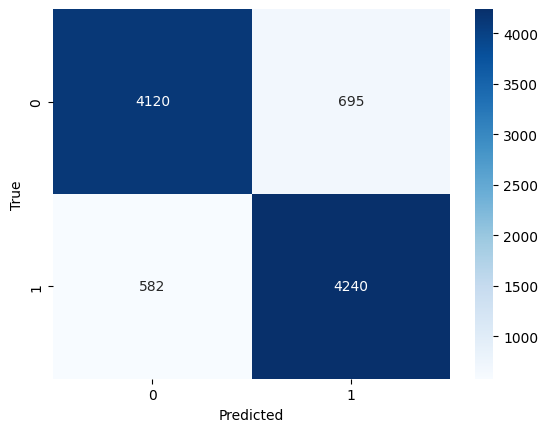

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, prediccion_bn_importado)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# Red Neuronal

## Vectorizer

In [ ]:
# Crea un objeto TfidfVectorizer y configura las stopwords
vectorizer_red = TfidfVectorizer(**vectorizer.get_params())
vectorizer_red.set_params(max_features = 10000)

TfidfVectorizer(max_features=10000,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                strip_accents='unicode')

In [ ]:
vectorizer_red.fit(x_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvie

TfidfVectorizer(max_features=10000,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                strip_accents='unicode')

In [ ]:
tfidf_red_x_train = vectorizer_red.transform(x_train).toarray()

In [ ]:
tfidf_red_x_test = vectorizer_red.transform(x_test).toarray()

## Implementación

In [ ]:
#max_len = max(len(seq) for seq in x_train_tfidf)

red_neuronal = keras.Sequential([

    #keras.layers.Dense(units = 55, batch_input_shape = (None, len(vectorizer_red.vocabulary_)), name = "CapaEntrada"),
    keras.layers.InputLayer(batch_input_shape = (None, len(vectorizer_red.vocabulary_)), dtype='float32', sparse=False, ragged=False),

    #keras.layers.Embedding(input_dim=10000, output_dim = 128, input_shape=[None]),#output_dim=20, input_length=max_sequence_length),
    #keras.layers.Flatten(),

    #keras.layers.Dense(units = 55, activation = "linear", name = "1CapaOculta"),

    keras.layers.Dense(units=50, activation='linear', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', input_shape=(None, len(vectorizer_red.vocabulary_))),
    keras.layers.Dense(units=50, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=L1L2(l1 = 0.009999999776482582, l2 = 0.009999999776482582), input_shape=(None, len(vectorizer_red.vocabulary_))),

    keras.layers.Dropout(0.5, name = "CapaDropOut"),

    #keras.layers.Dense(units = 55, kernel_regularizer = L1L2(l1 = 0.001, l2 = 0.001), activation = "relu", name = "2CapaOculta"),

    keras.layers.Dense(1, activation = "sigmoid", name = "CapaSalida")

], name = "RedSequential")


In [ ]:
red_neuronal.summary()

Model: "RedSequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                500050    
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 CapaDropOut (Dropout)       (None, 50)                0         
                                                                 
 CapaSalida (Dense)          (None, 1)                 51        
                                                                 
Total params: 502651 (1.92 MB)
Trainable params: 502651 (1.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
red_neuronal.compile(
  optimizer = keras.optimizers.Adam(learning_rate = 0.001),
  loss = 'binary_crossentropy',
  metrics = ["AUC"],
)

In [ ]:
red_neuronal.fit(tfidf_red_x_train, y_train, epochs = 15, batch_size = 25)

Epoch 1/15
1542/1542 [==============================] - 15s 9ms/step - loss: 0.7327 - auc: 0.8856
Epoch 2/15
1542/1542 [==============================] - 14s 9ms/step - loss: 0.3593 - auc: 0.9560
Epoch 3/15
1542/1542 [==============================] - 14s 9ms/step - loss: 0.3082 - auc: 0.9668
Epoch 4/15
1542/1542 [==============================] - 14s 9ms/step - loss: 0.2813 - auc: 0.9720
Epoch 5/15
1542/1542 [==============================] - 14s 9ms/step - loss: 0.2632 - auc: 0.9755
Epoch 6/15
1542/1542 [==============================] - 14s 9ms/step - loss: 0.2498 - auc: 0.9781
Epoch 7/15
1542/1542 [==============================] - 14s 9ms/step - loss: 0.2369 - auc: 0.9801
Epoch 8/15
1542/1542 [==============================] - 14s 9ms/step - loss: 0.2272 - auc: 0.9818
Epoch 9/15
1542/1542 [==============================] - 14s 9ms/step - loss: 0.2180 - auc: 0.9835
Epoch 10/15
1542/1542 [==============================] - 13s 9ms/step - loss: 0.2099 - auc: 0.9847
Epoch 11/15
1542/15

## Importación del Modelo

In [ ]:
red_importado = joblib.load("/content/sample_data/modelo_rn_2.joblib")

## Predicción

In [ ]:
prediccion_red = red_neuronal.predict(tfidf_red_x_test)

302/302 [==============================] - 1s 4ms/step


##Métricas

In [ ]:
prediccion_red = np.where(prediccion_red > 0.5, 1, 0)

In [ ]:
#Calculo las métricas
print("Accuracy: ", accuracy_score(y_test, prediccion_red))
print("Precision: ", precision_score(y_test, prediccion_red))
print("Recall: ", recall_score(y_test, prediccion_red))
print("f1 score: ", f1_score(y_test, prediccion_red))


Accuracy:  0.8672823492788212
Precision:  0.8747620055003174
Recall:  0.8575279966818747
f1 score:  0.8660592732223269


##Matriz de confusión

In [ ]:
cm = confusion_matrix(y_test, prediccion_red)

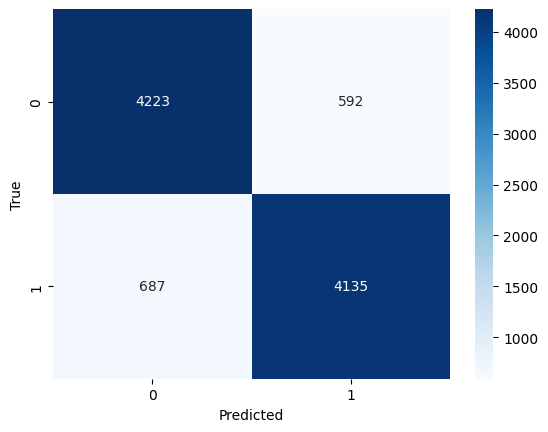

In [ ]:
sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# RandomForest

A continuación, se muestra la búsqueda de la optimización de los hiperparámetros y el entrenamiento del modelo de la importación

In [ ]:
parametros = {
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__n_estimators': [200, 300],
    'randomforestclassifier__max_depth': range(25,50),
    'randomforestclassifier__min_samples_split': range(2, 7),
    'randomforestclassifier__min_samples_leaf': range(1, 7),
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__ccp_alpha': np.linspace(0, 0.0001, 10),

    'tfidfvectorizer__max_features': [1000, 5000, 9000, 11000, 15000],
}


In [ ]:
random_forest = make_pipeline(vectorizer, RandomForestClassifier())
random_forest_cv = RandomizedSearchCV(random_forest, parametros, scoring='f1', n_iter=10, cv=5, random_state=17)
random_forest_cv.fit(x_train, y_train)

## Importación del Modelo

In [ ]:
random_forest_importado = joblib.load('/content/sample_data/modelo_rf_12.joblib')

In [ ]:
print("Mejores hiperparámetros:", random_forest_importado.best_params_)

Mejores hiperparámetros: {'tfidfvectorizer__max_features': 11000, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 38, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__ccp_alpha': 2.2222222222222223e-05}


In [ ]:
y_pred_randomForest = random_forest_importado.predict(x_test)

##Métricas

In [ ]:
#Calculo las métricas RandomForest
print("RandomForest")
print("Accuracy: ", accuracy_score(y_test, y_pred_randomForest))
print("Precision: ", precision_score(y_test, y_pred_randomForest))
print("Recall: ", recall_score(y_test, y_pred_randomForest))
print("f1 score: ", f1_score(y_test, y_pred_randomForest))

RandomForest
Accuracy:  0.8500570717028121
Precision:  0.8357526347186319
Recall:  0.871630029033596
f1 score:  0.8533143843264643


##Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

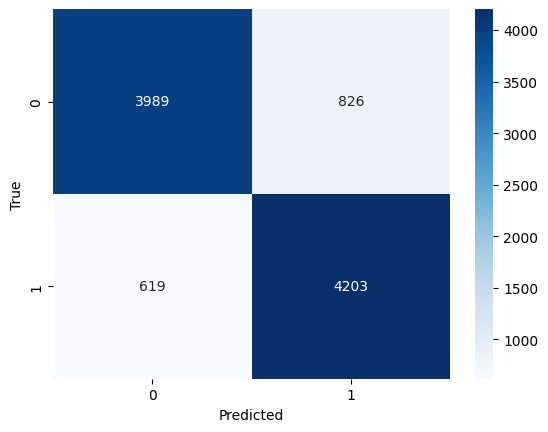

In [ ]:
#Matriz de Confusión TfidfVectorizer()
cm = confusion_matrix(y_test, y_pred_randomForest)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# XGBoost

## Importación del Modelo

In [ ]:
xgboost_importado = joblib.load('/content/sample_data/modelo_xgb_4.joblib')

##Métricas

In [ ]:
#hacemos predicciones en el conjunto de prueba
prediccion_xgb = xgboost_importado.predict(x_test)

In [ ]:
#Calculo las métricas
print("Accuracy: ", accuracy_score(y_test, prediccion_xgb))
print("Precision: ", precision_score(y_test, prediccion_xgb))
print("Recall: ", recall_score(y_test, prediccion_xgb))
print("f1 score: ", f1_score(y_test, prediccion_xgb))

TfidfVectorizer
Accuracy:  0.8526
Precision:  0.8461686933024513
Recall:  0.8662319699664098
f1 score:  0.8560827963288421


##Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

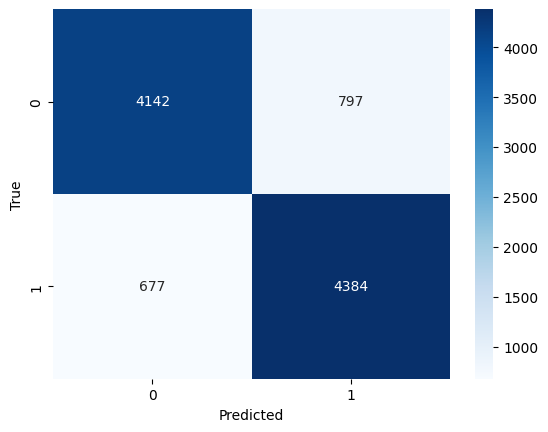

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, prediccion_xgb)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# XGBoost y RandomSearchCV

### Busqueda de los mejores hiperparámetros

In [ ]:
pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('xgb', xgb.XGBClassifier())
])

params_xgb = {
    'tfidf__max_features': [10000, 20000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'xgb__n_estimators': range(50, 200, 10),
    'xgb__max_depth': range(3, 10),
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'xgb__subsample': [0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

rand_xgb = RandomizedSearchCV(pipeline,
                              param_distributions=params_xgb,
                              n_iter=8,
                              cv=5,
                              verbose=1,
                              random_state=42,
                              n_jobs=-1)

rand_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvie

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words=['de',
                                                                          'la',
                                                                          'que',
                                                                          'el',
                                                                          'en',
                                                                          'y',
                                                                          'a',
                                                                          'los',
                                                                          'del',
                                                                          'se',
                                                                          'las',
                                                                          'por',
                                                                          'un',
                                                                          'para',
                                                                          'con',
                                                                          'no',
                                                                          'una',
                                                                          'su',
                                                                          'al',
                                                                          'lo',
                                                                          'como',
                                                                          'más',
                                                                          'pero',
                                                                          'sus',
                                                                          'le',
                                                                          'ya',
                                                                          'o',
                                                                          'este',
                                                                          'sí',
                                                                          'porque', ...],
                                                              strip_accents='unicode')),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None...
                                                            random_state=None, ...))]),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'tfidf__max_features': [10000, 20000],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)],
                                        'xgb__colsample_bytree': [0.6, 0.7, 0.8,
                                                                  0.9, 1.0],
                                        'xgb__learning_rate': [0.01, 0.1, 0.2,
                                                               0.3, 0.5],
                                        'xgb__max_depth': range(3, 10),
                                        'xgb__n_estimators': range(50, 200, 10),
                                        'xgb__subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, verbose=1)

In [ ]:
#Mejores hiperparametros
print(rand_xgb.best_params_)

#Mejor métrica
print(rand_xgb.best_score_)

{'xgb__subsample': 0.9, 'xgb__n_estimators': 180, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.3, 'xgb__colsample_bytree': 0.8, 'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 20000}
0.846925


### XGB con mejores parámetros

In [ ]:
#Mejor estimador
xgb_mejores_parametros = rand_xgb.best_estimator_

### Predicción

In [ ]:
#Predicción con mejor estimador
y_pred_xgb_rand = xgb_mejores_parametros.predict(x_test)

### Métricas

In [ ]:
#Calculo las métricas en el conjunto de evaluación
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb_rand))
print("Recall: ", recall_score(y_test, y_pred_xgb_rand))
print("Precision: ", precision_score(y_test, y_pred_xgb_rand))
print("f1 score: ", f1_score(y_test, y_pred_xgb_rand))

Accuracy:  0.8526
Recall:  0.8662319699664098
Precision:  0.8461686933024513
f1 score:  0.8560827963288421


### Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

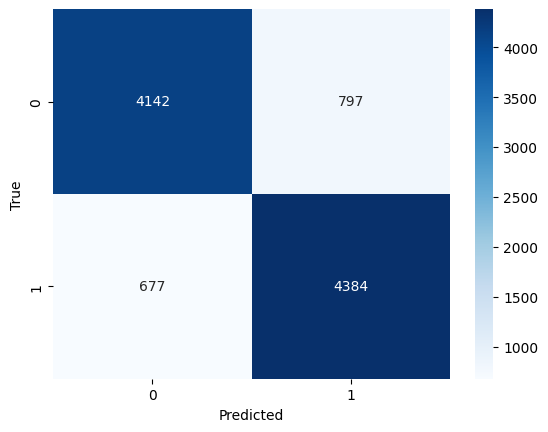

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_xgb_rand)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Importación del Modelo

In [ ]:
xgb_importado = joblib.load('/content/sample_data/modelo_xgb_5.joblib')

## Predicción

In [ ]:
prediccion_xgb_importado = xgb_importado.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvie

##Métricas

In [ ]:
#Calculamos las métricas
print("Accuracy: ", accuracy_score(y_test, prediccion_xgb_importado))
print("Precision: ", precision_score(y_test, prediccion_xgb_importado))
print("Recall: ", recall_score(y_test, prediccion_xgb_importado))
print("f1 score: ", f1_score(y_test, prediccion_xgb_importado))

Accuracy:  0.8586697104908166
Precision:  0.851340373679935
Recall:  0.8693488179178764
f1 score:  0.8602503591216909


##Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

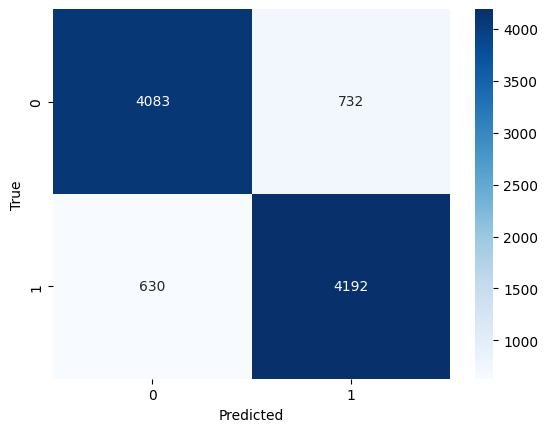

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, prediccion_xgb_importado)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# Voting

In [ ]:
#Creamos clasificadores
bayes_vot = bayes_importado
red_vot = red_importado
xgb_vot = xgboost_importado
rf_vot = random_forest_importado

#Creamos ensamble de Votación
voting = VotingClassifier(estimators = [('rf', rf_vot), ('xgb', xgb_vot), ('bayes', bayes_vot)],
                          voting = 'hard')

In [ ]:
#Entrenamos el ensamble
voting.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvie

VotingClassifier(estimators=[('rf',
                              RandomizedSearchCV(cv=5,
                                                 estimator=Pipeline(steps=[('tfidfvectorizer',
                                                                            TfidfVectorizer(stop_words=['de',
                                                                                                        'la',
                                                                                                        'que',
                                                                                                        'el',
                                                                                                        'en',
                                                                                                        'y',
                                                                                                        'a',
                                                                                                        'los',
                                                                                                        'del',
                                                                                                        'se',
                                                                                                        'las',
                                                                                                        'por',
                                                                                                        'un',
                                                                                                        'para',
                                                                                                        'con',
                                                                                                        'no',
                                                                                                        'una',
                                                                                                        'su',
                                                                                                        'al',
                                                                                                        'lo',
                                                                                                        'como',
                                                                                                        'más',
                                                                                                        'pero',
                                                                                                        'sus',
                                                                                                        'le',
                                                                                                        'ya',
                                                                                                        'o',
                                                                                                        'este',
                                                                                                        'sí',
                                                                                                        'porque', ...],
                                                                                            strip_accents='unicode')),
                                                                           ('randomforestclass...
                             ('bayes',
                              Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(max_features=15000,
                                                               ngram_range=(1,
                

##Métricas

In [ ]:
#hacemos predicciones en el conjunto de prueba
prediccion_voting = voting.predict(x_test)

In [ ]:
#Calculo las métricas
print("Accuracy: ", accuracy_score(y_test, prediccion_voting))
print("Precision: ", precision_score(y_test, prediccion_voting))
print("Recall: ", recall_score(y_test, prediccion_voting))
print("f1 score: ", f1_score(y_test, prediccion_voting))

Accuracy:  0.8562
Precision:  0.8389148737137512
Recall:  0.8859909108871764
f1 score:  0.8618104939458004


##Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

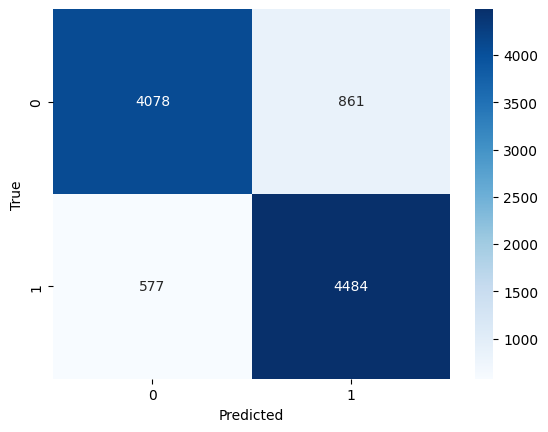

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, prediccion_voting)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# Stacking

## Vectorizer

In [ ]:
x_train_copy_2 = x_train
x_test_copy_2 = x_test

In [ ]:
# Carga las stopwords en español de NLTK
spanish_stopwords = stopwords.words('spanish')

# Crea un objeto TfidfVectorizer y configura las stopwords
vectorizer_stacking = TfidfVectorizer(stop_words=spanish_stopwords, strip_accents='unicode', max_features = 7000)

In [ ]:
vectorizer_stacking.fit(x_train_copy_2)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvie

TfidfVectorizer(max_features=7000,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                strip_accents='unicode')

In [ ]:
x_train_tfidf_2 = vectorizer_stacking.transform(x_train_copy_2).toarray()

In [ ]:
x_test_tfidf_2 = vectorizer_stacking.transform(x_test_copy_2).toarray()

## Modelo

In [ ]:
#Modelos Base
base_models = [('rf', RandomForestClassifier(n_estimators = 100)),
               ('bayes', MultinomialNB())
               ]

#Meta Modelo
meta_model = XGBClassifier()

#Creamos el ensamble Stacking
stacking = StackingClassifier(estimators=base_models,
                              final_estimator=meta_model,
                              passthrough=True,
                              cv=5,
                              verbose=2)

In [ ]:
#Entrenamos el ensamble
stacking.fit(x_train_tfidf_2, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier()),
                               ('bayes', MultinomialNB())],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=None, gamma=None,
                                                 gro...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   passthrough=True, verbose=2)

## Predicción

In [ ]:
#hacemos predicciones en el conjunto de prueba
prediccion_stacking = stacking.predict(x_test_tfidf_2)

##Métricas

In [ ]:
#Calculo las métricas
print("Accuracy: ", accuracy_score(y_test, prediccion_stacking))
print("Precision: ", precision_score(y_test, prediccion_stacking))
print("Recall: ", recall_score(y_test, prediccion_stacking))
print("f1 score: ", f1_score(y_test, prediccion_stacking))

Accuracy:  0.868
Precision:  0.865403399101387
Recall:  0.8753210827899625
f1 score:  0.8703339882121808


##Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

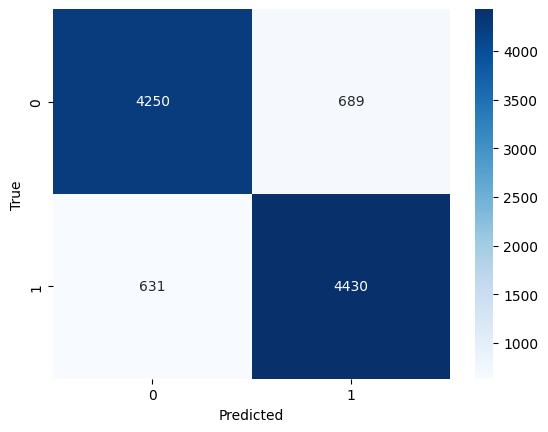

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, prediccion_stacking)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## Importación del Modelo

In [ ]:
stacking_importado = joblib.load('/content/sample_data/modelo_stacking_2.joblib')

## Predicción

In [ ]:
prediccion_stacking_importado = stacking_importado.predict(x_test_tfidf_2)

##Métricas

In [ ]:
#Calculamos las métricas
print("Accuracy: ", accuracy_score(y_test, prediccion_stacking_importado))
print("Precision: ", precision_score(y_test, prediccion_stacking_importado))
print("Recall: ", recall_score(y_test, prediccion_stacking_importado))
print("f1 score: ", f1_score(y_test, prediccion_stacking_importado))

Accuracy:  0.8629333333333333
Precision:  0.845333667837431
Recall:  0.891166358106321
f1 score:  0.8676451654435433


##Matriz de confusión

Text(50.722222222222214, 0.5, 'True')

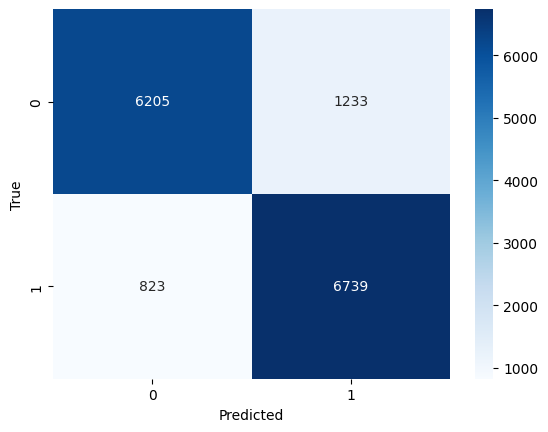

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test, prediccion_stacking_importado)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# Predicción con DF_CRITICAS_TEST

## Carga del DataFrame TEST

In [ ]:
DF_CRITICAS_TEST = pd.read_csv(("/content/sample_data/test.csv"))

In [ ]:
df_criticas_test_copy = DF_CRITICAS_TEST.copy()

## Preprocesamiento

In [ ]:
df_criticas_test_copy['review_es'] = df_criticas_test_copy['review_es'].apply(eliminar_caracteres_especiales)

### Red Neuronal

In [ ]:
x_test_tfidf_red = vectorizer_red.transform(df_criticas_test_copy['review_es']).toarray()

### Stacking

In [ ]:
x_test_tfidf_2 = vectorizer_stacking.transform(df_criticas_test_copy['review_es']).toarray()

## Predicción del conjunto de test y submits para la competencia Kaggle

### Red

In [ ]:
test_pred = red_neuronal.predict(x_test_tfidf_red)
print(test_pred)

269/269 [==============================] - 1s 3ms/step
[[0.00101751]
 [0.03523044]
 [0.00939064]
 ...
 [0.97239906]
 [0.00173887]
 [0.2488157 ]]


###Stacking

In [ ]:
test_pred = stacking.predict(x_test_tfidf_2)
print(test_pred)

[0 0 0 ... 1 0 0]


###Otros modelos

In [ ]:
test_pred = bn_mejores_parametros.predict(df_criticas_test_copy.review_es)
print(test_pred)

[0 0 0 ... 1 0 0]


### Resultado

In [ ]:
test_pred = np.where(test_pred > 0.5, "positivo", "negativo").flatten()

In [ ]:
df_resultado = pd.DataFrame(
    {"ID": DF_CRITICAS_TEST["ID"],
    "sentimiento": test_pred}
)

In [ ]:
df_resultado.head()

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,negativo


### Exportación

In [ ]:
df_resultado.to_csv("resultado_red_10.csv", index=False)

# Guardado del modelo

In [ ]:
joblib.dump(red_neuronal, "red_note_original.joblib")

['red_note_original.joblib']